При подготовке ноутбука использовались материалы:
1. [LDA topic modelling lenta Kaggle](https://www.kaggle.com/genyagree/lda-topic-modelling/notebook)
2. [LDA topic modelling visualization](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)
3. [LDA topic modelling](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)

# Введение
**Latent Dirichlet Allocation** (LDA) - статистическая модель, позволяющая разделить набор текстов на $N$ подгрупп.

Каждый кластер характеризуется набором из $X$ ключевых слов. Эти ключевые слова ассоциируются с темой (topic). 

Каждый документ может быть представлен абором тем, каждая тема может быть представлена набором ключевых слов.

### Пример
У нас есть 3 документа:<br>
<br>
D1 = "Собаки любят играть"<br>
D2 = "Кошки любят молоко"<br>
D3 = "Кошки и собаки любят кушать и играть. Я люблю собак. Они милые"<br>

Topic Modelling может выдать следующую модель:<br>
<br>
D1 = 100% Topic1 + 0% Topic2<br>
D2 = 0% Topic1 + 100% Topic2<br>
D3 = 70% Topic1 + 30% Topic2<br>
<br>
Где каждая тема сформирована из слов (в порядке убывания значимости):<br>
<br>
Topic1 = 30% собака, 30% играть, 20% нравиться 10% милая 10% любить<br>
Topic2 = 50% кошка, 30% молоко, 20% нравиться<br>



# Зачем нужно LDA Topic Modeling

Общая задача тематического моделирования - обнаружение скрытой структуры в наборе текстовых данных. 
Для маленького количества текстов мы могли бы использовать просто tf-idf информацию, но для большого числа документов этого уже не достаточно

Практические применения:

1. [Суммаризация мнений](https://dl.acm.org/doi/10.1145/1076034.1076161)
Управляющим организациям, чьи решения влияют на большие группы людей может быть полезно суммаризовать информацию с выражением мнений из открытых источников (постов и комментариев в соцсетях)

2. [Bioinformatics](https://springerplus.springeropen.com/articles/10.1186/s40064-016-3252-8)
Применение метода к "microarray datasets" - датасетам с последовательностями аминокилот или нуклеотидов - для выявления сткрытой структуры этих данных.

3. [Отслеживание трендов в тематиках корпусов текстов](https://timreview.ca/article/1170)
Анализ корпуса текстов - научных публикаций на определенную тему - позволяет отследить, как меняется взгляд на ту или иную научную проблему

4. [Рекомендательные системы](https://habr.com/ru/company/surfingbird/blog/150607/)
Если представить пользователя как набор описания продуктов, которые ему понравились, то можно находить тематики, интересующие пользователя и делать рекомендации в соответствии с ними.



   
# Немного теории
В latent diriclet allocaton (LDA) модели каждый документ в корпусе представляется в виде набора тем в соответствии с распределением Дирихле.

##  Постановка проблемы
- Коллекция документов $D$
- Каждый документ $d$ из коллекции представлен набором слов $W_{d} = (w_{1}, ..., w_{n_{d}})$ из словаря $W$, где $n_{d}$ - длина документа $d$
- Каждому документу соответствует набор тем
- Порядком слов в документе пренебрегают: каждый документ рассматривается как bag-of-words
- Каждая тема $t\in T$ (где $T$ - набор тем) описывается распределением Дирихле $p(w|t)$ на наборе слов $w\in W$, то есть тема представлена в виде вектора $\phi_{t} = (p(w|t):w \in W)$
- Каждый документ $d\in D$ описывается распределением Дирихле $p(t|d)$ на наборе тем $t\in T$. То есть документ описывается вектором $\theta_{d} = (p(t|d):t \in T)$
<br>

![](https://editor.analyticsvidhya.com/uploads/26864dtm.JPG)

Вероятность "возникновения" пары "документ-слово" можно записать следующим образом:

$$
p(w|d)=\sum\limits_{t\in T}p(w|t)p(t|d)
$$

![](https://miro.medium.com/max/780/1*QiTvyHNwvGI5UCqeKvhNsg.png)

## Решение
Построить модель тематического моделирования значит найти матрицы $\Phi = ||p(w|t)||$ и $\Theta = ||p(t|d)||$ на основе коллекции документов $D$.


Для нахождения решения нужно ршеить оптимизационную задачу - максимизировать следующую функцию (максимизируем likelihood наших данных с такими матрицами): 
$$
\sum\limits_{d\in D}\sum\limits_{w\in d}n_{dw}logp(w|d)\to\max\limits_{\Phi,\Theta},
$$
где $n_{dw}$ - частота слова $w$ в документе $d$.

In [43]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint
import json
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
%matplotlib inline
import nltk
import pymorphy2
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Загрузка данных

In [5]:
DATA_DIR = "data"
DATA_FILE = "lenta-ru-news.csv"

In [6]:
rus_data = pd.read_csv(os.path.join(DATA_DIR, DATA_FILE)).dropna()

C:\ProgramData\Anaconda3\envs\topic_modelling_2\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
rus_data.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


In [8]:
rus_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712654 entries, 0 to 739175
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     712654 non-null  object
 1   title   712654 non-null  object
 2   text    712654 non-null  object
 3   topic   712654 non-null  object
 4   tags    712654 non-null  object
 5   date    712654 non-null  object
dtypes: object(6)
memory usage: 38.1+ MB


In [9]:
rus_data['topic'].value_counts()

Россия               155004
Мир                  136620
Экономика             76423
Спорт                 57894
Культура              53530
Наука и техника       53136
Бывший СССР           51370
Интернет и СМИ        44421
Из жизни              27513
Дом                   21734
Силовые структуры     11223
Ценности               7581
Бизнес                 7375
Путешествия            6370
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Оружие                    3
ЧМ-2014                   2
МедНовости                1
Сочи                      1
Name: topic, dtype: int64

## Чистка данных

In [10]:
def clean_data(df):
    rusdata_df = df[(df['topic']!='Библиотека')&(df['topic']!='Бывший СССР')&(df['topic']!='69-я параллель')].reset_index(drop=True).sample(10000, random_state = 42)
    rusdata = rusdata_df['text']
    return rusdata_df, rusdata

In [11]:
rusdata_df, rusdata = clean_data(rus_data)

In [12]:
rusdata

47040     На одном из заводов в городе Салфит на Западно...
47827     Госсекретарь США Колин Пауэлл вновь встретился...
437317    МТС предложила сократить срок эмбарго на строи...
155505    Экс-чемпион мира по боксу Константин Цзю посту...
580672    Народный художник России, кинодекоратор Алекса...
                                ...                        
389799    Руководство американской газеты USA Today попр...
295325    Папу Римского Бенедикта XVI толкнула паломница...
152201    Михаил Фрадков назначил нового заместителя рук...
518313    Посетитель кладбища в районе Вены Хернальс Ман...
270969    В Санкт-Петербурге умер народный артист России...
Name: text, Length: 10000, dtype: object

# Обработка данных

1. Удаление стоп-слов
2. Токенизация
2. Лемматизация
3. Построение словаря n-грамм
4. Tf-idf кодирование

 ## Удаление стоп-слов

1. Стоп-слова из библиотеки nltk
2. Дополнительный набор стоп-слов №1 ([github](https://github.com/stopwords-iso/stopwords-ru))
3. Дополнительный набор стоп-слов №2 ([github](https://github.com/Alir3z4/stop-words))

In [18]:
STOPWORDS_DIR = "stopwords"

In [19]:
def get_stop_words():
    stopwordsrus = list(stopwords.words('russian'))
    with open(os.path.join(STOPWORDS_DIR, "russian.txt")) as f:
        stop_words_1 = f.read().split("\n")
    with open(os.path.join(STOPWORDS_DIR, "stopwords-ru.txt")) as f:
        stop_words_2 = f.read().split("\n")
    return list(set(stopwordsrus+stop_words_1+stop_words_2))

In [20]:
stopwordsru = get_stop_words()

### Токенизация

In [21]:
def process(text):
    return list(t.lower() for t in word_tokenize(text) if t.isalpha() and t.lower() not in stopwordsru)

In [22]:
data = [process(t) for t in rusdata]

## Лемматизация

In [23]:
morph = pymorphy2.MorphAnalyzer()
def lemmatizer(texts):
    return [[morph.parse(word)[0] for word in text] for text in texts]

In [24]:
morph_data = lemmatizer(data)

In [25]:
def extract_lemma(texts):
    norm = []
    for t in texts:
        res = []
        for word in t:
            n = word.normal_form
            res.append(n)
        norm.append(res)
    return norm

In [26]:
# This is our lemmatized data ready to be used further:
data_norm = extract_lemma(morph_data)

# Визуализация

In [27]:
def wordcloud_visualization(list_of_tokenized_sentences):
    # Join the different processed titles together.
    long_string = ','.join([','.join(x) for x in list_of_tokenized_sentences])

    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    return wordcloud.to_image()

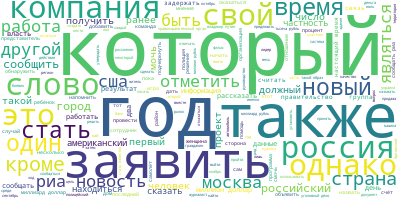

In [28]:
wordcloud_visualization(data_norm)

## Построение n-грамм

*Смотри документацию [Phrases](https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.Phrases) и [Phraser](https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.FrozenPhrases). Phraser ускоряет работу Phrases*

In [30]:
bigram = gensim.models.Phrases(data_norm, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_norm], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [31]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_trigrams = make_trigrams(data_norm)

In [32]:
print(data_words_trigrams[0])

['один', 'завод', 'город', 'салфита', 'западный_берег', 'израильский', 'военный', 'обнаружить', 'называть', 'пояс_шахид', 'предназначить', 'совершение_теракт', 'посредством', 'самоубийство', 'сообщать', 'издание', 'сведение', 'израильский', 'спецслужба', 'исламский', 'экстремист', 'подготовить', 'около', 'сто', 'который', 'планироваться', 'направить', 'иерусалим', 'данные', 'ряд', 'источник', 'финансировать', 'подобный', 'процесс', 'подготовка', 'теракт', 'мочь', 'структура', 'базироваться', 'саудовский_аравия', 'агентство', 'выяснить', 'накануне', 'саудовский_аравия', 'счёт', 'семья', 'самоубийца', 'джамаль', 'нассера', 'поступить', 'тысяча', 'доллар', 'именно', 'человек', 'совершить', 'теракт', 'район', 'наблус', 'врезаться', 'автобус', 'машина', 'загрузить', 'взывчатка', 'подобный', 'платёж', 'семья', 'погибнуть', 'палестинский', 'террорист', 'регулярно', 'проходить', 'саудовский_аравия', 'утверждать', 'источник', 'среда', 'министр_внутренний_дело', 'саудовский_аравия', 'найефа', 'б

## Создание словаря n-gram и BOW

*Смотри документацию [Dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary) и [doc2bow](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2bow).*

In [34]:
dictionary = corpora.Dictionary(data_words_trigrams)

corpus = [dictionary.doc2bow(doc) for doc in data_words_trigrams]
# We will also try to filter unimportant words by their tf-idf score, so let's create the tf-idf scores here too


In [35]:
dictionary[8]

'взывчатка'

## Encoding Tf-Idf

TF-IDF = Term Frequency (TF) * Inverse Document Frequency (IDF)

[Статья с хорошим описанием](https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089)

$t$ — term (word)<br>
$d$ — document (set of words)<br>
$D$ - коллекция документов<br>
$N$ — размер коллекции документов $D$<br>


$$tf(t,d) = \frac{n_{td}}{n_{d}}$$
Частота встречаемости слова в документе.<br>
$n_{td}$ - количество встречаний слова $t$ в документе $d$, $n_{d}$ - количество слов в документе $d$<br>
<br>
$$df(t) = \sum_d{n_{td}}$$
Встречаемость слова в корпусе.<br>
$n_{td}$ - количество встречаний слова $t$ в документе $d$, $n_{d}$ - количество слов в документе $d$<br>
<br>
$$idf(t) = log(\frac{N}{df(t)+1})$$
Обратная встречаемость слова в корпусе.<br>
<br>

**$$tfidf(t,d) = tf(t,d)*idf(t)$$**

In [36]:
tfidf = gensim.models.TfidfModel(corpus, id2word = dictionary)

# Построение модели LDA Topic Modelling

## Использование корпуса без TF-IDF фильтрации

In [41]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=80, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [42]:
pprint(lda_model.show_topics(formatted=False))

[(15,
  [('snakespit', 1.5475802e-05),
   ('revolver', 1.5475802e-05),
   ('слэш', 1.5475802e-05),
   ('валентайна', 1.5475802e-05),
   ('velvet', 1.5475802e-05),
   ('trick', 1.5475802e-05),
   ('стивить', 1.5475802e-05),
   ('slash', 1.5475802e-05),
   ('alter', 1.5475802e-05),
   ('cheap', 1.5475802e-05)]),
 (18,
  [('стоять', 0.092247106),
   ('зал', 0.07123697),
   ('ссср', 0.06239722),
   ('флаг', 0.06136522),
   ('медаль', 0.05787919),
   ('одержать_победа', 0.04963959),
   ('бежать', 0.03999174),
   ('служебный', 0.031912938),
   ('детство', 0.03001526),
   ('тасс_ссылка', 0.024627455)]),
 (1,
  [('подать', 0.17894323),
   ('иск', 0.15580593),
   ('алексей', 0.101264015),
   ('родственник', 0.09140528),
   ('разбиться', 0.049927283),
   ('настроить', 0.038580716),
   ('каир', 0.021052016),
   ('красноярский_край', 0.006354978),
   ('валентайна', 5.520384e-06),
   ('слэш', 5.520384e-06)]),
 (78,
  [('сокращение', 0.081969514),
   ('оператор', 0.0805623),
   ('рассматривать', 0.0

In [62]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame (index=range(10000), columns = ['Dominant_Topic1', 'Dominant_Topic2', '%Topic_Contribution1', '%Topic_Contribution2', 'Topic_Keywords1', 'Topic_Keywords2'])
    
    # Get main topic in each document
    for i, text in enumerate(ldamodel[corpus]):
        text = text[0]
        text = sorted(text, key=lambda x: x[1], reverse=True) #sort % contributions of topic  
        # Get the Dominant topic, % of topic contribution and Keywords for each document
        for j, (topic_num, topic_contrib) in enumerate(text):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.Dominant_Topic1[i] = int(topic_num)
                sent_topics_df['%Topic_Contribution1'][i] = round(topic_contrib,4)
                sent_topics_df['Topic_Keywords1'][i] = topic_keywords
                
                #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                
            elif j == 1:  # => second dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.Dominant_Topic2[i] = int(topic_num)
                sent_topics_df['%Topic_Contribution2'][i] = round(topic_contrib,4)
                sent_topics_df['Topic_Keywords2'][i] = topic_keywords
                
            else:
                break
    

    # Add original text to the end of the output
    contents = pd.Series(texts, name = "text")
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=rusdata.values)


df_dominant_topic = df_topic_sents_keywords.reset_index(drop = True)
df_dominant_topic.head(10)

,Dominant_Topic1,Dominant_Topic2,%Topic_Contribution1,%Topic_Contribution2,Topic_Keywords1,Topic_Keywords2,text
0,33,53,0.1608,0.1557,"год, который, сообщать, время, стать, один, пе...","страна, власть, город, территория, гражданин, ...",На одном из заводов в городе Салфит на Западно...
1,49,73,0.1663,0.1543,"россия, также, российский, год, ранее, сообщит...","сша, американский, январь, условие, reuters, п...",Госсекретарь США Колин Пауэлл вновь встретился...
2,49,33,0.3941,0.0967,"россия, также, российский, год, ранее, сообщит...","год, который, сообщать, время, стать, один, пе...",МТС предложила сократить срок эмбарго на строи...
3,49,33,0.1777,0.1529,"россия, также, российский, год, ранее, сообщит...","год, который, сообщать, время, стать, один, пе...",Экс-чемпион мира по боксу Константин Цзю посту...
4,54,49,0.1651,0.1589,"автор, история, роман, старый, институт, многи...","россия, также, российский, год, ранее, сообщит...","Народный художник России, кинодекоратор Алекса..."
5,76,49,0.2001,0.1994,"счёт, рамка, минута, чемпионат, михаил, товар,...","россия, также, российский, год, ранее, сообщит...","Мадридский ""Реал"" обеспечил себе победу в чемп..."
6,75,49,0.2262,0.1584,"военный, ирак, войско, комплекс, афганистан, в...","россия, также, российский, год, ранее, сообщит...",Бюджетный комитет федерального парламента Герм...
7,49,47,0.2957,0.2167,"россия, также, российский, год, ранее, сообщит...","автомобиль, машина, граница, завод, наиболее, ...",Продажи нового бюджетного седана Nissan Almera...
8,33,49,0.1279,0.1019,"год, который, сообщать, время, стать, один, пе...","россия, также, российский, год, ранее, сообщит...","Двое американцев, занимавшихся мошенничеством ..."
9,33,49,0.1778,0.1236,"год, который, сообщать, время, стать, один, пе...","россия, также, российский, год, ранее, сообщит...",Более четверти бывших министров администрации ...


In [67]:
df_dominant_topic.loc[2]["text"]

'МТС предложила сократить срок эмбарго на строительство сетей стандарта связи LTE в Краснодарском крае для тех операторов, которые не являются партнерами Олимпийских игр в Сочи, пишет «Коммерсантъ». Эмбарго предлагается отменить в конце 2014 года, тогда как сейчас оно действует до декабря 2016 года. МТС направила соответствующее письмо в Минсвязи. Компания отмечает, что является лидером по количеству абонентов в крае и ограничение на строительство новых сетей рассматривает как несправедливое. Как передает издание, 2 июля комиссия по радиочастотам (ГКРЧ) может рассмотреть сокращение срока эмбарго, но решение будет отрицательным, поскольку против этого выступил Роскомнадзор. Кроме того, решение установлено федеральным законом, так что у ГКРЧ может не оказаться полномочий, чтобы его отменить. Услуги в ходе Олимпиады могут оказывать «МегаФон» и «Ростелеком», являющиеся ее генеральными партнерами. В других же компаниях решение об эмбарго до конца 2016 года считают «технической ошибкой», пос

In [70]:
df_dominant_topic.loc[2]["Topic_Keywords1"]

'россия, также, российский, год, ранее, сообщить, день, данные, кроме, другой'

In [63]:
df_dominant_topic.to_csv('./results/dominant_topic_no_tfidf_limit.csv', index= False)

## Визуализация

In [97]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_news_no_tfidf_limits')

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_news_no_tfidf_limits' +'.html')
LDAvis_prepared

C:\ProgramData\Anaconda3\envs\topic_modelling_2\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
49     0.310135 -0.253149       1        1  17.099140
33     0.302281 -0.303984       2        1  15.749061
63     0.246118  0.040059       3        1   6.718920
27     0.210358  0.081825       4        1   3.937845
5      0.200592  0.098733       5        1   3.885527
...         ...       ...     ...      ...        ...
78    -0.111736 -0.028202      76        1   0.231715
56    -0.110301 -0.020924      77        1   0.222916
1     -0.125785 -0.024298      78        1   0.192441
18    -0.150188 -0.028688      79        1   0.151087
15    -0.230606 -0.037133      80        1   0.003446

[80 rows x 5 columns], topic_info=           Term          Freq         Total Category  logprob  loglift
179         год  25832.000000  25832.000000  Default  30.0000  30.0000
38      который  17878.000000  17878.000000  Default  29.0000  29.0000
196    компания   6037.000000   6037.000000  Default  28.0000  28.0000
113     человек   5437.000000   5437.000000  Default  27.0000  27.0000
156        свой   6796.000000   6796.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
24        завод      0.000623    429.748283  Topic80 -11.0762  -3.1690
25    загрузить      0.000623     34.163252  Topic80 -11.0762  -0.6370
26   заниматься      0.000623   1095.636636  Topic80 -11.0762  -4.1049
28     заявлять      0.000623    404.537691  Topic80 -11.0762  -3.1086
29    иерусалим      0.000623    100.815856  Topic80 -11.0762  -1.7191

[2968 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
4446     55  0.980660                 a
3088      9  0.996572               afp
428       9  0.995621            agence
650       7  0.998186  associated_press
1514     23  0.983902               bbc
...     ...       ...               ...
847       9  0.985193            январь
648      15  0.997798            япония
907      17  0.997295          японский
2110     25  0.968127         ярославль
4193     45  0.978596              ясно

[2269 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[50, 34, 64, 28, 6, 61, 54, 38, 74, 11, 42, 73, 35, 21, 12, 20, 63, 31, 78, 53, 37, 77, 47, 29, 39, 4, 41, 76, 56, 27, 69, 44, 15, 23, 55, 71, 7, 62, 59, 52, 72, 17, 10, 80, 68, 60, 40, 22, 36, 1, 13, 48, 3, 14, 65, 32, 25, 8, 49, 18, 51, 70, 5, 46, 33, 30, 45, 9, 26, 67, 58, 43, 66, 75, 24, 79, 57, 2, 19, 16])

# Оценка качества

### Perplexity

[Подробное описание](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94)


Оценка генеративной языковой модели.

Мы хотим, чтобы наша языковая модель приписывала высокие вероятности реальным предложениям и низкие - нереальным. Поэтому чем ниже PP, тем лучше.


$PP(W)$ - обратная вероятность тестового корпуса слов, нормированная на его размер

$$PP(W) = \frac1{P(w_1,...,w_N)^{\frac1N}}$$


In [45]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.


Perplexity:  -36.39095235470305


# Задание

## Использование корпуса c TF-IDF фильтрацией (10 баллов)

TFIDF коэффициенты выделяют слова, которые являются часто употребимыми (не несут информации о конкретном документе) или те, которые встречаются только в одном документе и не могут показать скрытую связь между документами. 

В этом задании нужно
1. Найти максимальное и минимальное значение tfidf скора

*Подсказка*: нужно проитерироваться по всему корпусу слов, посчитать tfidf скор и найти пороговые значения

2. Построить дискретный массив tfidf скоров с шагом 0.005 и найти перцентили 10 и 95

3. Отфильтровать corpus в filtered_corpus, оставив только слова со скорами, попадающими в диапазон от 10 до 95 перцентилей.
4. Построить подель LDA на отфильтрованном корпусе
5. Посчитать метрики качества
5. Сделать визуализацию тематик
6. Посмотреть на темы с наибольшими коэффициентами в датафрейме
7. Напишите, какой вывод можно сделать

**Комментарий** - можно уменьшать количество  $n_topics$, если вашему компьютеру не хватает вычислительных мощностей.

**Комментарий** - если при визуализации вы получили ошибку `TypeError: Object of type complex is not JSON serializable`, добавьте в метод `prepare` аргумент `mds='mmds'`

## Дополнительное задание (5 баллов)

Постройте LDA Topic modelling модель для [датасета постов о политике с Пикабу](https://www.kaggle.com/atomin/pikabu-politic-posts). 

При построении можете поизменять параметры `alpha` и `beta` для получения более качественной модели.

Какие выводы можно сделать на основе полученной модели?

In [ ]:

tf_max = #YOUR_CODE
tf_min = #YOUR_CODE
print(tf_max, tf_min)
tfidf_range = #YOUR_CODE

print(np.percentile(tfidf_range, 95), np.percentile(tfidf_range, 10))

In [38]:
low_value = np.percentile(tfidf_range, 10) 
high_value = np.percentile(tfidf_range, 95) 

filtered_corpus = []
for i in range(0, len(corpus)):
        
    filter_ids = #YOUR_CODE
   
    new_bow = #YOUR_CODE
      
    filtered_corpus.append(new_bow)

In [82]:
lda_model_tfidf = #YOUR_CODE

In [83]:
# Show Topics
pprint(lda_model_tfidf.show_topics(formatted=False))

[(34,
  [('snakespit', 1.5475802e-05),
   ('revolver', 1.5475802e-05),
   ('слэш', 1.5475802e-05),
   ('валентайна', 1.5475802e-05),
   ('velvet', 1.5475802e-05),
   ('trick', 1.5475802e-05),
   ('стивить', 1.5475802e-05),
   ('slash', 1.5475802e-05),
   ('alter', 1.5475802e-05),
   ('cheap', 1.5475802e-05)]),
 (44,
  [('snakespit', 1.5475802e-05),
   ('revolver', 1.5475802e-05),
   ('слэш', 1.5475802e-05),
   ('валентайна', 1.5475802e-05),
   ('velvet', 1.5475802e-05),
   ('trick', 1.5475802e-05),
   ('стивить', 1.5475802e-05),
   ('slash', 1.5475802e-05),
   ('alter', 1.5475802e-05),
   ('cheap', 1.5475802e-05)]),
 (13,
  [('snakespit', 1.5475802e-05),
   ('revolver', 1.5475802e-05),
   ('слэш', 1.5475802e-05),
   ('валентайна', 1.5475802e-05),
   ('velvet', 1.5475802e-05),
   ('trick', 1.5475802e-05),
   ('стивить', 1.5475802e-05),
   ('slash', 1.5475802e-05),
   ('alter', 1.5475802e-05),
   ('cheap', 1.5475802e-05)]),
 (52,
  [('snakespit', 1.5475802e-05),
   ('revolver', 1.5475802

In [86]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_news_with_tfidf')

LDAvis_prepared = #YOUR_CODE
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_with_no_tfidf' +'.html')
LDAvis_prepared

C:\ProgramData\Anaconda3\envs\topic_modelling_2\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
41     0.427692  0.033073       1        1  3.315873
5      0.183917  0.309363       2        1  3.124598
22     0.325356  0.270014       3        1  3.114157
1     -0.367516 -0.063728       4        1  2.701882
73     0.223593 -0.273546       5        1  2.673219
...         ...       ...     ...      ...       ...
39    -0.006156 -0.000034      76        1  0.074927
44    -0.006157 -0.000034      77        1  0.074724
56    -0.006156 -0.000034      78        1  0.074724
34    -0.006156 -0.000033      79        1  0.074724
57    -0.006155 -0.000033      80        1  0.074724

[80 rows x 5 columns], topic_info=                Term         Freq        Total Category  logprob  loglift
1241         процент  7802.000000  7802.000000  Default  30.0000  30.0000
105              сша  3780.000000  3780.000000  Default  29.0000  29.0000
420            фильм  3243.000000  3243.000000  Default  28.0000  28.0000
196         компания  3166.000000  3166.000000  Default  27.0000  27.0000
1184         украина  3134.000000  3134.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
21            доллар     0.004568  2323.281522  Topic80 -11.0762  -5.9402
22            житель     0.004568   282.399070  Topic80 -11.0762  -3.8328
24             завод     0.004568  1095.923466  Topic80 -11.0762  -5.1888
27    западный_берег     0.004568    45.708513  Topic80 -11.0762  -2.0118
29         иерусалим     0.004568   264.539310  Topic80 -11.0762  -3.7675

[2901 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
4446     67  0.915896            a
649      21  0.297061          aol
1515      5  0.985309     bbc_news
4523     15  0.791765          bmw
1300     11  0.967785       boeing
...     ...       ...          ...
3742      2  0.941114        юноша
3545     27  0.963340         юрий
3875     59  0.783533   юрисдикция
1882     48  0.963344        юрист
118      25  0.945216  ясир_арафат

[724 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[42, 6, 23, 2, 74, 44, 69, 13, 79, 4, 71, 78, 48, 47, 24, 31, 66, 19, 15, 65, 27, 68, 25, 60, 54, 67, 18, 26, 11, 37, 64, 50, 76, 72, 63, 10, 12, 51, 73, 36, 43, 46, 41, 28, 75, 8, 5, 16, 21, 59, 62, 49, 33, 1, 34, 70, 20, 32, 29, 30, 55, 56, 17, 77, 52, 38, 9, 80, 7, 22, 61, 3, 39, 53, 14, 40, 45, 57, 35, 58])

In [ ]:
print('\nPerplexity: ', #YOUR_CODE)  

In [ ]:
df_topic_sents_keywords = #YOUR_CODE


df_dominant_topic = df_topic_sents_keywords.reset_index(drop = True)
df_dominant_topic.head(10)

In [92]:
df_dominant_topic.to_csv('./results/dominant_topic_with_tfidf_limit.csv', index= False)

In [ ]:
df_dominant_topic.loc[2]["text"]

In [ ]:
df_dominant_topic.loc[2]["Topic_Keywords2"]